# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Учим VAE


In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)


11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
547/547 [==============================] - 6s 11ms/step - loss: 210.1050 - reconstruction_loss: 207.7417 - kl_loss: 2.3632
Epoch 2/10
547/547 [==============================] - 6s 10ms/step - loss: 184.8997 - reconstruction_loss: 183.1290 - kl_loss: 1.7707
Epoch 3/10
547/547 [==============================] - 6s 11ms/step - loss: 171.0339 - reconstruction_loss: 168.4224 - kl_loss: 2.6115
Epoch 4/10
547/547 [==============================] - 6s 11ms/step - loss: 157.2545 - reconstruction_loss: 154.0318 - kl_loss: 3.2227
Epoch 5/10
547/547 [==============================] - 6s 11ms/step - loss: 154.4944 - reconstruction_loss: 151.1644 - kl_loss: 3.3300
Epoch 6/10
547/547 [==============================] - 6s 10ms/step - loss: 152.8854 - reconstruction_loss: 149.5134 - kl_loss: 3.3720
Epoch 7/10
547/547 [==============================] - 6s 10ms/step - loss: 151.8389 - reconstruction_loss: 148.4188 - kl_loss: 3.42

In [9]:
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 6s 11ms/step - loss: 149.3047 - reconstruction_loss: 145.8041 - kl_loss: 3.5005
Epoch 2/10
547/547 [==============================] - 6s 10ms/step - loss: 148.9397 - reconstruction_loss: 145.4325 - kl_loss: 3.5072
Epoch 3/10
547/547 [==============================] - 6s 10ms/step - loss: 148.5864 - reconstruction_loss: 145.0756 - kl_loss: 3.5108
Epoch 4/10
547/547 [==============================] - 6s 10ms/step - loss: 148.2665 - reconstruction_loss: 144.7330 - kl_loss: 3.5335
Epoch 5/10
547/547 [==============================] - 6s 10ms/step - loss: 147.9847 - reconstruction_loss: 144.4553 - kl_loss: 3.5294
Epoch 6/10
547/547 [==============================] - 6s 11ms/step - loss: 147.6850 - reconstruction_loss: 144.1318 - kl_loss: 3.5532
Epoch 7/10
547/547 [==============================] - 6s 11ms/step - loss: 147.5000 - reconstruction_loss: 143.9431 - kl_loss: 3.5568
Epoch 8/10
547/547 [==============================] - 6s 11ms/

## Результат предсказания для цифры


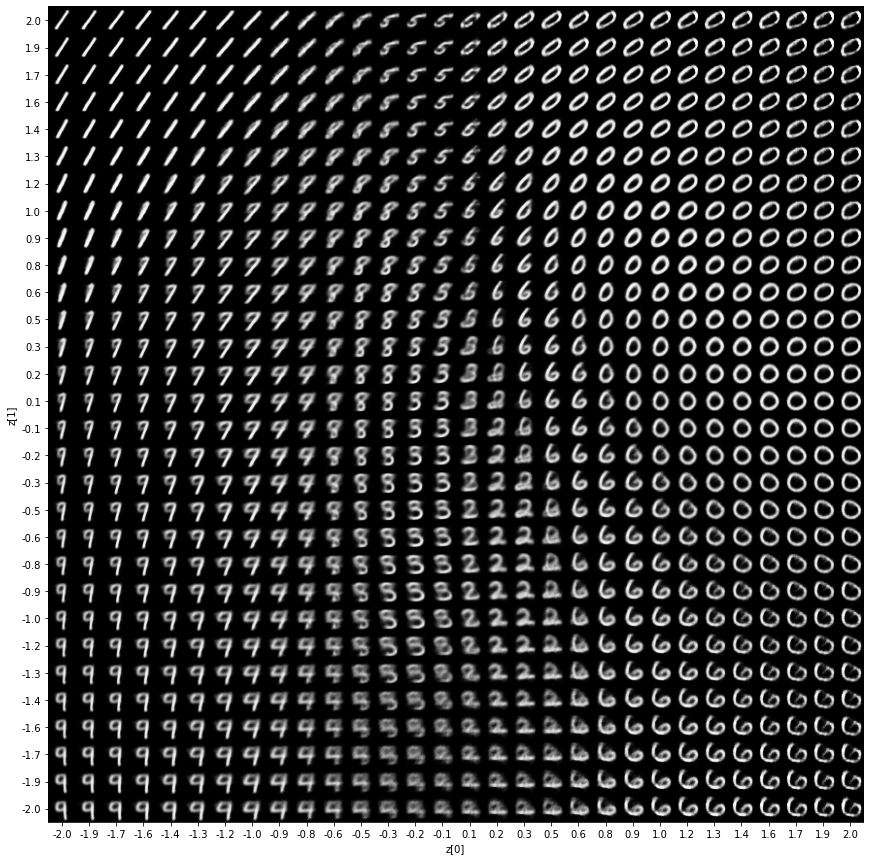

In [10]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


## Посмотрим на кластеры в скрытом пространстве для цифр


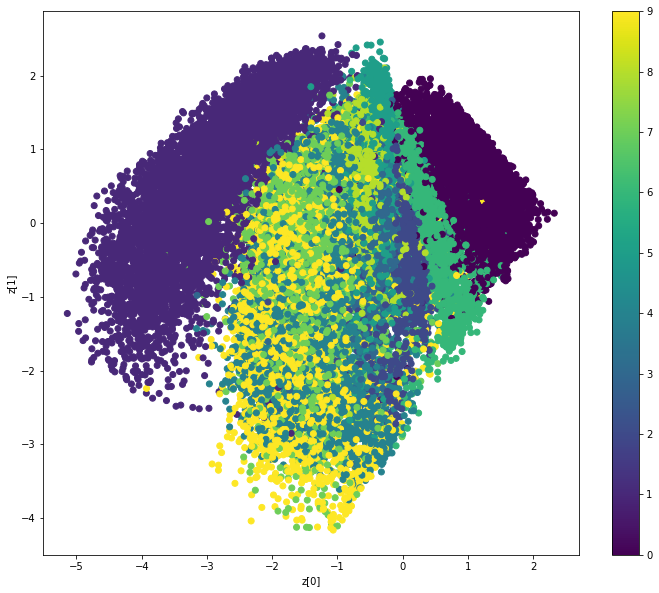

In [8]:

def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)
